# An analysis of the State of the Union speeches - Part 1

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import shelve

from collections import Counter
import datetime
import os

plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize'] = (10, 6)

We first need to load in the data from the text file and break it into speeches. We also will create a data frame of presidents and addresses/dates.

In [2]:
# Addresses is a dataframe with all the basic data for the addresses:
with open("data/stateoftheunion1790-2017.txt") as f:
    raw_text = f.read()
#Addresses are separated by three asterisks as noted by the txt
sections = raw_text.split("***")
#First index is contents. All others are speeches
speeches = sections[1:]
#Get CONTENTS section
start = sections[0].find("CONTENTS")
#Get rid of 'CONTENTS'
addresses = sections[0][start:].replace("CONTENTS\n\n", "")
#Each address is seperated by a newline. Get rid of last two rows of space
addresses = addresses.split("\n")[:-2]
#Turn extra spaces into one space
addresses = [' '.join(address.split()) for address in addresses]
#We know each line has President, Title of Address, and Date
addresses = [address.split(",") for address in addresses]
#Join the seperated dates caused by the above split.
addresses = [address[:2] + [address[2] + " " + address[3]] for address in addresses]
addresses = pd.DataFrame(addresses)
addresses.columns = ["president", "title", "date"]
addresses["date"] = pd.to_datetime(addresses["date"])
addresses.head()

,president,title,date
0,George Washington,State of the Union Address,1790-01-08
1,George Washington,State of the Union Address,1790-12-08
2,George Washington,State of the Union Address,1791-10-25
3,George Washington,State of the Union Address,1792-11-06
4,George Washington,State of the Union Address,1793-12-03


Let's take a first look at a high-level summary of what we have so far:

In [3]:
# Describe the presidents data
print("Summary of presidents data")
print(addresses["president"].describe())
print()
print("Franklin D. Roosevelt addresses")
print(addresses[addresses["president"] == "Franklin D. Roosevelt"])
print()
print("List of Presidents who delivered addressses")
print(addresses["president"].unique())

Summary of presidents data
count                       227
unique                       42
top       Franklin D. Roosevelt
freq                         12
Name: president, dtype: object

Franklin D. Roosevelt addresses
                 president                        title       date
140  Franklin D. Roosevelt   State of the Union Address 1934-01-03
141  Franklin D. Roosevelt   State of the Union Address 1935-01-04
142  Franklin D. Roosevelt   State of the Union Address 1936-01-03
143  Franklin D. Roosevelt   State of the Union Address 1937-01-06
144  Franklin D. Roosevelt   State of the Union Address 1938-01-03
145  Franklin D. Roosevelt   State of the Union Address 1939-01-04
146  Franklin D. Roosevelt   State of the Union Address 1940-01-03
147  Franklin D. Roosevelt   State of the Union Address 1941-01-06
148  Franklin D. Roosevelt   State of the Union Address 1942-01-06
149  Franklin D. Roosevelt   State of the Union Address 1943-01-07
150  Franklin D. Roosevelt   State of the Un

Non-surprisingly, Franklin D. Roosevelt, the only president to serve more than two terms, appeared the most times in the data, delivering a total of 12 addresses.  

Even though there are 45 presidents, there are only a total of 42 presidents in this dataframe. The missing presidents are: William Henry Harrison, who passed away one month into his presidency and James A. Garfield, who was assassinated in his first year. Grover Cleveland counts as 2 presidents because he was elected in two non-consecutive terms, the only time to happen in U.S. history!

Let's find the dates of the first and last address, and how much time has passed between those:

In [4]:
# This is roughly the number of years between the first and last address:

begin = addresses["date"].min()
print("First address: " + str(begin))
end = addresses["date"].max()
print("Last address: " + str(end))

print("Years passed: " + str(end.year - begin.year + (end.month - begin.month)/12 + (end.day - begin.day)/365.25))

First address: 1790-01-08 00:00:00
Last address: 2017-02-27 00:00:00
Years passed: 227.13535249828885


227 years have passed between the first address by George Washington on January 8th, 1790 and the most current address by Donald Trump on February 27, 2017.

Let's see during which months are the speeches most frequently delivered:

In [5]:
# This is a count of the number of addresses delivered on any given month

#Get the month from each date
months = addresses["date"]
months = [month.strftime("%B") for month in months]
months = pd.Series(months)
months.name = "Address counts"

#Count how many addresses occur in each month.
acounts = months.value_counts()
months_list = ['January', 'February', 'March', 'April','May','June', 'July', 'August',
               'September', 'October', 'November', 'December']
#If a month does not appear, we know its count is 0.
for month in months_list:
    if month not in acounts.index:
        acounts[month] = 0
#Sort months.  
acounts.index = pd.CategoricalIndex(acounts.index, categories= months_list, sorted=True)
acounts = acounts.sort_index()
acounts

January       75
February      12
March          0
April          0
May            0
June           0
July           0
August         0
September      2
October        3
November      11
December     124
Name: Address counts, dtype: int64

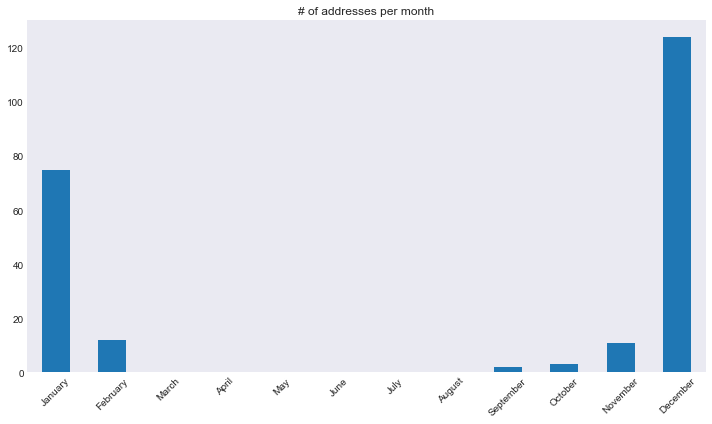

In [6]:
# And this is a plot of these:
os.makedirs("fig", exist_ok=True)

plot = acounts.plot(kind = "bar", title = "# of addresses per month", rot = 45)
plot.figure.tight_layout()
plt.savefig('fig/addresses_month.png');

Most of the addresses are delivered during January and December, most likely to outline the agenda and goals of the new year.

Let's look at the distribution of differences between successive speeches:

Where is the largest gap? We can ask the `ddiff` series for its location:

In [7]:
# this is the index of the largest gap:
ddiff = addresses["date"].diff() 
dgap = ddiff.idxmax()
dgap

104

Let's look at the dates around this index:

In [8]:
dates = addresses["date"]
print(dates[dgap-2 : dgap+2])
print()
print(addresses.iloc[dgap-1])
print()
print(addresses.iloc[dgap])

102   1891-12-09
103   1892-12-06
104   1897-12-06
105   1898-12-05
Name: date, dtype: datetime64[ns]

president              Benjamin Harrison
title         State of the Union Address
date                 1892-12-06 00:00:00
Name: 103, dtype: object

president               William McKinley
title         State of the Union Address
date                 1897-12-06 00:00:00
Name: 104, dtype: object


As well as a plot of these times:

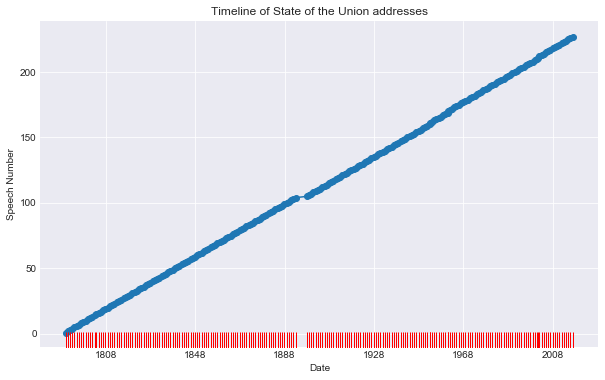

In [9]:
# A plot of the times, along with 'rug' markers on the x axis.

dates_df = dates.reset_index()
dates_df.columns = ["Speech Number", "Date"]
dates_df["Speech Number"] += 1

plt.plot_date(data= dates_df, x =  "Date", y = "Speech Number", linestyle = 'solid')
plt.title("Timeline of State of the Union addresses")
plt.grid()
plt.xlabel("Date")
plt.ylabel("Speech Number")
dates_df["Rug"] = plt.ylim()[0]

plt.plot_date(data= dates_df, x =  "Date", y = "Rug", marker = "|", color = "red", ms = 30)
plt.ylim(dates_df["Rug"][0])
f = plt
f.savefig('fig/timeline.png')


There is a gap between the addresses delivered in 1892 by Benjamin Harrison and in 1897 by William McKinley. What happened at that gap? The presidency between the gap was the second term of Grover Cleveland, but he still delivered addresses in this time period according to online sources (http://www.presidency.ucsb.edu/sou.php). Thus, this gap is caused by the data not containing these addresses.

## Intermediate results

Let's save some intermediate results for further analysis. This lets us work on subsequent notebooks  without rerunning this one.  We use the Pandas HDF5 support for efficient and type-safe serialization of data frames, and the python builtin [shelve](https://docs.python.org/3/library/shelve.html) module for simple Python variables.  We'll create for each notebook variable stores with the notebook number, one for dataframes (`df1.h5`, `df2.h5`, etc.) and one for python variables (`vars1.db`, `vars2.db`, etc.).  These will all go into the `results/` subdirectory.

In [10]:
os.makedirs("results", exist_ok=True) #Make results directory if it does not exist yet
addresses.to_hdf('results/df1.h5', 'addresses')
with shelve.open('results/vars1') as db:
    db['speeches'] = speeches